# 1. Setup

## 1.1 Install Dependencies

In [2]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [3]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2024-07-31 09:58:02.591516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 09:58:02.591669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 09:58:02.704647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1.3 Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
#gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus: 
#    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [54]:
# Setup paths
POS_PATH = os.path.join('/kaggle/input/facial-recognition-data/data', 'positive')
NEG_PATH = os.path.join('/kaggle/input/facial-recognition-data/data', 'negative')
ANC_PATH = os.path.join('/kaggle/input/facial-recognition-data/data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# https://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ unlabelled Wild dataset
!tar -xf lfw.tgz

In [ ]:
# Move from lfw folder to Negatives folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        OLD_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(OLD_PATH,NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [ ]:
# Import uuid to generate unique image names
import uuid

In [ ]:
# Establish a connection with webcam
cap=cv2.VideoCapture(0)

while cap.isOpened():
    
    ret,frame=cap.read()
    
    # Cut down frame to 250x250
    frame=frame[120:370,200:450,:]
    
    # Collect Anchors
    if cv2.waitKey(1) & 0xFF==ord('a'):
        # Create a unique file path
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname,frame)
    
    # Collect Positives
    if cv2.waitKey(1) & 0xFF==ord('p'):
        # Create a unique file path
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname,frame)
    
    # Show image to screen
    cv2.imshow('Image Collection',frame)
    
    # Break Connection
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break

# Release Webcam
cap.release()
# Destroy all Windows
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [7]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [8]:
dir_test=anchor.as_numpy_iterator()

In [9]:
dir_test.next()

b'/kaggle/input/facial-recognition-data/data/anchor/fe7fa5de-4acd-11ef-8488-489ebde9a4a1.jpg'

## 3.2 Preprocessing - Scale and Resize

In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

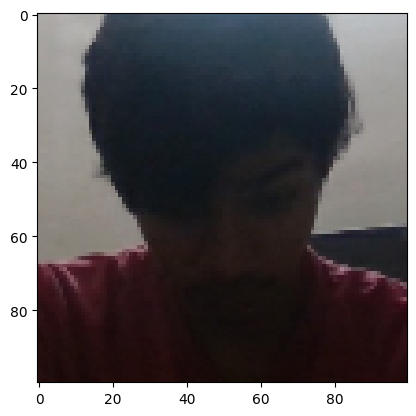

In [11]:
img=preprocess('/kaggle/input/facial-recognition-data/data/anchor/0ee02546-4ace-11ef-86f9-489ebde9a4a1.jpg')
plt.imshow(img)

In [12]:
print(img)
print(img.numpy().max())
print(img.numpy().min())

tf.Tensor(
[[[0.66862744 0.66862744 0.6607843 ]
  [0.6735294  0.6696078  0.65392154]
  [0.68921566 0.6764706  0.6637255 ]
  ...
  [0.7411765  0.74509805 0.7607843 ]
  [0.7382353  0.74215686 0.75784314]
  [0.7382353  0.74215686 0.75784314]]

 [[0.6735294  0.6696078  0.6598039 ]
  [0.67720586 0.67034316 0.65563726]
  [0.68235296 0.6666667  0.654902  ]
  ...
  [0.7323529  0.7362745  0.7519608 ]
  [0.7355392  0.73946077 0.75514704]
  [0.7362745  0.74019605 0.7558824 ]]

 [[0.67745095 0.6735294  0.6578431 ]
  [0.6764706  0.6696078  0.654902  ]
  [0.6762255  0.6605392  0.6487745 ]
  ...
  [0.7264706  0.73039216 0.74607843]
  [0.7264706  0.73039216 0.74607843]
  [0.722549   0.7264706  0.74215686]]

 ...

 [[0.14607844 0.06666667 0.0627451 ]
  [0.14019608 0.06102941 0.05906863]
  [0.1252451  0.05122549 0.05294118]
  ...
  [0.14215687 0.04779412 0.05637255]
  [0.13406862 0.04779412 0.05563726]
  [0.13357843 0.04730392 0.05808824]]

 [[0.14215687 0.05980392 0.05588235]
  [0.14093137 0.05955882 0

# 3.3 Create Labelled Dataset

In [13]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
samples = data.as_numpy_iterator()

In [16]:
example=samples.next()
example

(b'/kaggle/input/facial-recognition-data/data/anchor/0b4f3231-4ace-11ef-8e67-489ebde9a4a1.jpg',
 b'/kaggle/input/facial-recognition-data/data/positive/38c903dd-4ace-11ef-a011-489ebde9a4a1.jpg',
 1.0)

# 3.4 Build Train and Test Partition

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*example)

In [ ]:
plt.imshow(res[0])
plt.show()
plt.imshow(res[1])
plt.show()

In [20]:
res[2]

1.0

In [21]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [22]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [24]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [25]:
embedding = make_embedding()

In [26]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [27]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [28]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [29]:
input_image = Input(name='input_img', shape=(100,100,3))
inp_embedding=embedding(input_image)[0]
validation_image = Input(name='validation_img', shape=(100,100,3))
val_embedding=embedding(validation_image)[0]

In [30]:
siamese_layer = L1Dist()

In [31]:
distances = siamese_layer(inp_embedding, val_embedding)

In [32]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_12>

In [33]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [34]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image)[0], embedding(validation_image)[0])
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [36]:
siamese_model = make_siamese_model()

In [37]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [38]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [39]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [40]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [41]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [42]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [43]:
EPOCHS = 50

In [44]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step

 E

# 6. Evaluate Model

## 6.1 Import Metrics

In [45]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [46]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [47]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1722421484.369268     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([[9.99999523e-01],
       [2.72853491e-08],
       [2.05441358e-10],
       [4.25936157e-08],
       [9.96908128e-01],
       [2.18454573e-12],
       [1.06174146e-10],
       [9.99957085e-01],
       [2.22194507e-09],
       [2.06017976e-08],
       [1.22434558e-05],
       [9.99776900e-01],
       [1.89135335e-06],
       [1.00000000e+00],
       [1.58151137e-09],
       [2.16752394e-09]], dtype=float32)

In [48]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]

In [49]:
y_true

array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [50]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [51]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [53]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [ ]:
L1Dist

In [55]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [56]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


array([[9.99999523e-01],
       [2.72853491e-08],
       [2.05441358e-10],
       [4.25936157e-08],
       [9.96908128e-01],
       [2.18454573e-12],
       [1.06174146e-10],
       [9.99957085e-01],
       [2.22194507e-09],
       [2.06017976e-08],
       [1.22434558e-05],
       [9.99776900e-01],
       [1.89135335e-06],
       [1.00000000e+00],
       [1.58151137e-09],
       [2.16752394e-09]], dtype=float32)

In [57]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [61]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images')):
        input_img = preprocess(os.path.join('/kaggle/input/input-image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [81]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('/kaggle/input/application-data2/application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()

[ WARN:0@956.527] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@956.527] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


In [70]:
def verify_pos(model,img_path, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images')):
        input_img = preprocess(os.path.join('/kaggle/input/input-images/Input Images/Positives', img_path))
        validation_img = preprocess(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

def verify_neg(model,img_path, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images')):
        input_img = preprocess(os.path.join('/kaggle/input/input-images/Input Images/Negatives', img_path))
        validation_img = preprocess(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('/kaggle/input/application-data2/application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

Positive Images used for Verification


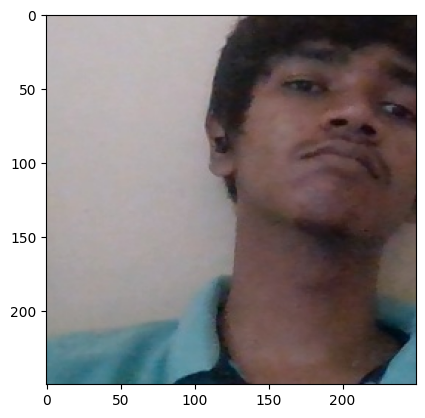

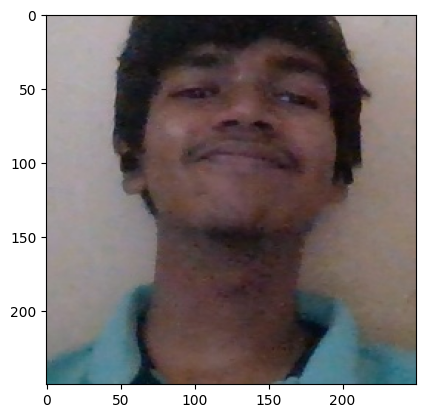

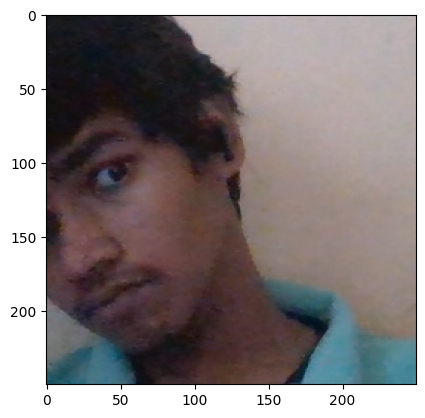

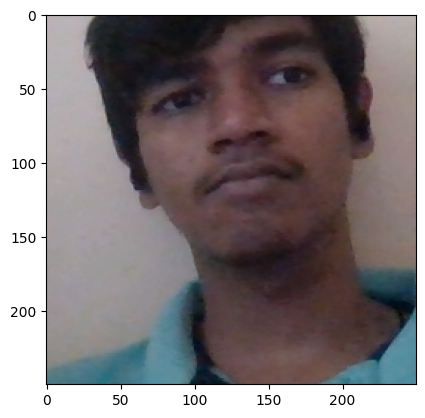

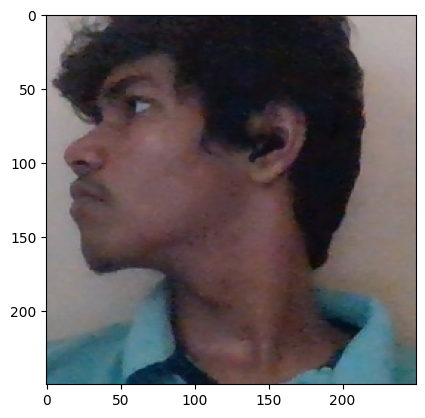

Negative Images used for Verification


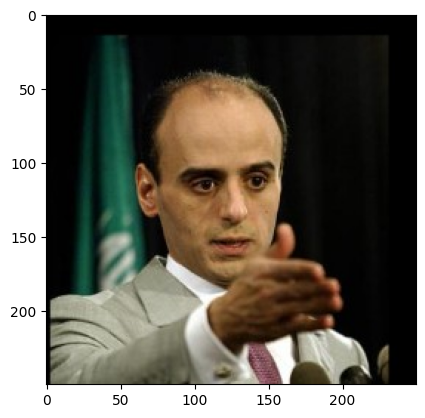

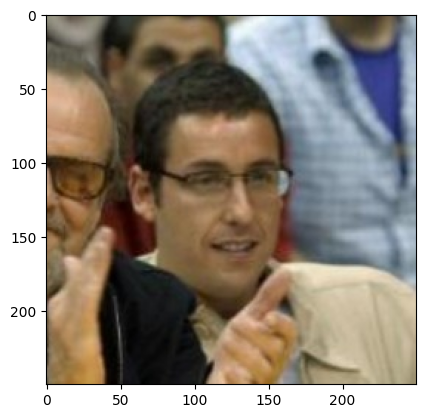

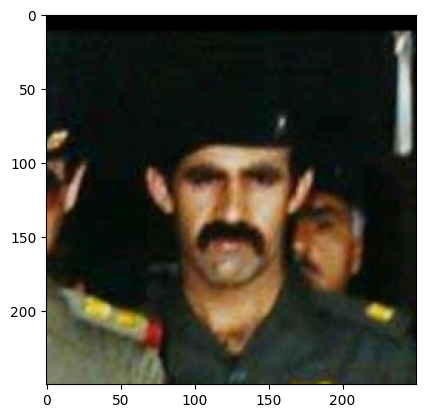

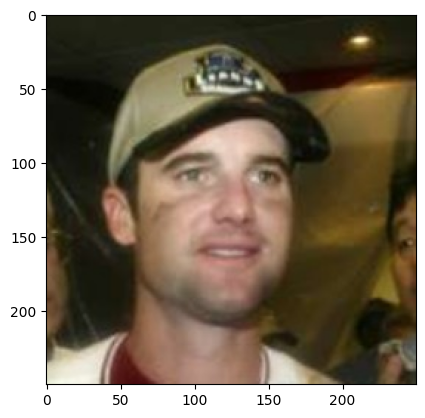

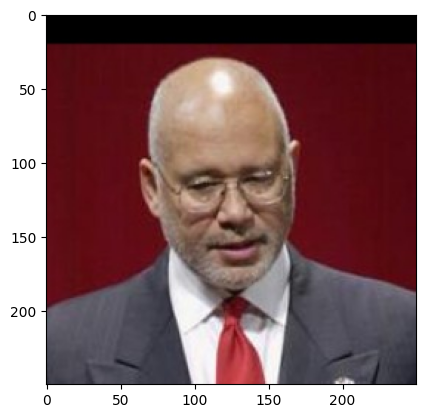

In [83]:
print('Positive Images used for Verification')
for img in os.listdir(os.path.join('/kaggle/input/input-images/Input Images','Positives')):
    img_r=cv2.imread(os.path.join('/kaggle/input/input-images/Input Images','Positives',img))
    img_r=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
    plt.imshow(img_r)
    plt.show()
print('Negative Images used for Verification')
for img in os.listdir(os.path.join('/kaggle/input/input-images/Input Images','Negatives')):
    img_r=cv2.imread(os.path.join('/kaggle/input/input-images/Input Images','Negatives',img))
    img_r=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
    plt.imshow(img_r)
    plt.show()

In [85]:
pos_images=[]
for img in os.listdir(os.path.join('/kaggle/input/input-images/Input Images','Positives')):
    results, verified = verify_pos(siamese_model,img, 0.5, 0.5)
    pos_images.append(1 if verified==True else 0)

neg_images=[]
for img in os.listdir(os.path.join('/kaggle/input/input-images/Input Images','Negatives')):
    results, verified = verify_neg(siamese_model,img, 0.5, 0.5)
    neg_images.append(1 if verified==True else 0)

print('Positive Images Prediction:',pos_images)
print('Accuracy of Positive Images is:',sum(pos_images)*100/len(pos_images))
print('Negative Images Prediction:',neg_images)
print('Accuracy of Negative Images is:',(len(neg_images)-sum(neg_images))*100/len(neg_images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

3